In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
#Import client_id, client_secret, etc from external .json file (to keep user details out of the .ipynb file).
df = pd.read_json("/Users/arnavprasad/Google Drive/Documents/Coding/Spotify/auth_details.json", typ="series")

username = df["username"]
client_id = df["client_id"]
client_secret = df["client_secret"]
redirect_uri = df["redirect_uri"]

In [5]:
scope = "user-top-read" #define your desired goal

In [6]:
token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

Couldn't read cache at: .cache-arnav7
Couldn't read cache at: .cache-arnav7
Couldn't write token to cache at: .cache-arnav7


In [7]:
sp = spotipy.Spotify(auth=token)

In [8]:
ranges = ["short_term", "medium_term", "long_term"]

for sp_range in ranges:
    print(sp_range + "\n")
    results = sp.current_user_top_tracks(time_range=sp_range, limit=10)
    for i, item in enumerate(results["items"]):
        print(str(i+1) + " " + item["name"] + " // " + item["artists"][0]["name"])
    print("\n")


short_term

1 Does It Make You Feel Good? // Joesef
2 Out Of My Head // Mac DeMarco
3 Old Fashioned // Bruno Major
4 Karma Police // Scary Pockets
5 I Wonder Why // Joesef
6 New York, New York (Live) // Jon Batiste
7 With Love To An Ex (feat. Moonchild Sanelly) // Gorillaz
8 Something // Vulfpeck
9 MLS (feat. JPEGMAFIA and CHAI) // Gorillaz
10 The Recipe // SiR


medium_term

1 Herside Story // GoldLink
2 Tribe (with J. Cole) // Bas
3 If You’re Too Shy (Let Me Know) // The 1975
4 Sunblind // Fleet Foxes
5 Out Of My Head // Mac DeMarco
6 The Tracks Of My Tears // Smokey Robinson & The Miracles
7 The Recipe // SiR
8 Great Dane - Radio Edit // Cosmo Pyke
9 CUT EM IN (feat. Rick Ross) // Anderson .Paak
10 Baguetti (with JID & Kenny Beats) // Smino


long_term

1 Freaking Out the Neighborhood // Mac DeMarco
2 If I Ever Get Around To Living // John Mayer
3 Waitin' On The Day // John Mayer
4 Still Beating // Mac DeMarco
5 My 1-Bedroom // Theo Katzman
6 SUGAR // BROCKHAMPTON
7 What Did You Mea

In [10]:
alltime = sp.current_user_top_tracks(time_range="long_term", limit=50)["items"]

In [11]:
df = pd.DataFrame({"Track name":[], "Track ID":[], "popularity":[]})

In [12]:
alltime[0].keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

In [13]:
for i, track in enumerate(alltime):
    df.loc[i] = [track["name"], track["id"], track["popularity"]]

In [14]:
df.head()

,Track name,Track ID,popularity
0,Freaking Out the Neighborhood,25SJaCCPiosugnlY53VhRG,73.0
1,If I Ever Get Around To Living,6Oi3mUl8WwfTVRqEwByZ7R,50.0
2,Waitin' On The Day,58ImA5yX8b5UkLy9MDXwWO,57.0
3,Still Beating,2N4idqj9TT3HnH2OFT9j0v,68.0
4,My 1-Bedroom,1wkU8NjA4JzwszL61vCmnu,35.0


In [15]:
test = df["Track ID"][0]

In [16]:
sp.audio_features(tracks=[test])

[{'danceability': 0.565,
  'energy': 0.832,
  'key': 8,
  'loudness': -5.751,
  'mode': 0,
  'speechiness': 0.108,
  'acousticness': 0.0639,
  'instrumentalness': 0.0291,
  'liveness': 0.386,
  'valence': 0.847,
  'tempo': 143.302,
  'type': 'audio_features',
  'id': '25SJaCCPiosugnlY53VhRG',
  'uri': 'spotify:track:25SJaCCPiosugnlY53VhRG',
  'track_href': 'https://api.spotify.com/v1/tracks/25SJaCCPiosugnlY53VhRG',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/25SJaCCPiosugnlY53VhRG',
  'duration_ms': 173889,
  'time_signature': 4}]

In [17]:
features = ["danceability", "energy", "loudness", "acousticness", "instrumentalness", "liveness", "tempo"]

for i in range(df.shape[0]):
    track_id = df["Track ID"][i]
    feature_dictionary = sp.audio_features(tracks=[track_id])[0]
    for feature in features:
        df.loc[i, feature] = feature_dictionary[feature]

In [18]:
df.head()

,Track name,Track ID,popularity,danceability,energy,loudness,acousticness,instrumentalness,liveness,tempo
0,Freaking Out the Neighborhood,25SJaCCPiosugnlY53VhRG,73.0,0.565,0.832,-5.751,0.0639,0.029100,0.386,143.302
1,If I Ever Get Around To Living,6Oi3mUl8WwfTVRqEwByZ7R,50.0,0.559,0.468,-12.738,0.5320,0.129000,0.257,80.014
2,Waitin' On The Day,58ImA5yX8b5UkLy9MDXwWO,57.0,0.656,0.438,-8.631,0.7970,0.052200,0.142,119.996
3,Still Beating,2N4idqj9TT3HnH2OFT9j0v,68.0,0.709,0.496,-10.528,0.5810,0.195000,0.151,78.477
4,My 1-Bedroom,1wkU8NjA4JzwszL61vCmnu,35.0,0.552,0.323,-11.672,0.8080,0.000284,0.102,176.514


Text(0.5, 1.0, "Arnav's 50 all-time top tracks: tempos")

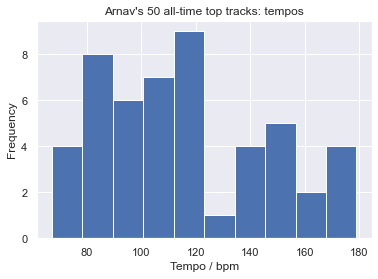

In [19]:
plt.figure()
plt.hist(df["tempo"])
plt.xlabel("Tempo / bpm")
plt.ylabel("Frequency")
plt.title("Arnav's 50 all-time top tracks: tempos")

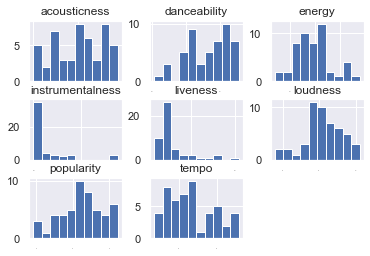

In [20]:
df.hist(xlabelsize=0);

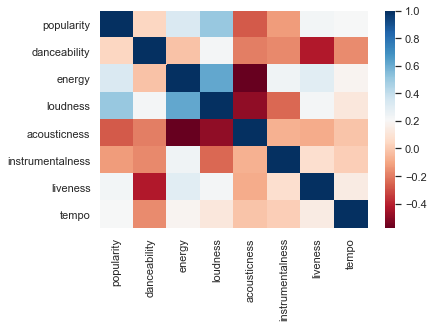

In [21]:
sns.heatmap(df.corr(), cmap=plt.cm.get_cmap("RdBu"))